TFG


*   AUTOR: JORGE NAVARRO ALLUEVA
*   TUTOR: ADRIAN NAVAS
*   TITULO: Mejora de un simulador de incendios forestales para su uso en entornos reales


In [1]:
import leafmap
import numpy as np
import matplotlib.pyplot as plt  # Para representar gráficamente los datos de elevación
import matplotlib.patches as mpatches
import rasterio
import requests  # Para enviar solicitudes HTTP a la API
import json  # Para trabajar con datos JSON
import io
import cv2
from rasterio.io import MemoryFile
from owslib.wms import WebMapService
from PIL import Image
#output.enable_custom_widget_manager()
import funciones_tfg

In [2]:
Mapa = funciones_tfg.crear_mapa()

In [4]:
Mapa

Map(bottom=786614.0, center=[40.99518838768076, -1.388826370239258], controls=(ZoomControl(options=['position'…

In [5]:
# Obtener las figuras dibujadas (asegúrate de que se dibuje un rectángulo)
features = Mapa.draw_features

#Base numerica para definir la precision
base_res = 0.00003 

Nx, Ny, min_lon, max_lon, min_lat, max_lat, center_lat, marker_lon, marker_lat, lon_distances, lat_distances = funciones_tfg.procesar_dominio(features, base_res)

Caja delimitadora: (-1.401774, 40.975363) hasta (-1.3669601607051873, 40.996213000000004)
Relación de aspecto: 1.6705171835307757, Nx: 876, Ny: 695
Coordenadas del marcador: (-1.391301, 40.977048)


Factor de escala utilizado: 4.504504504503873
194 154


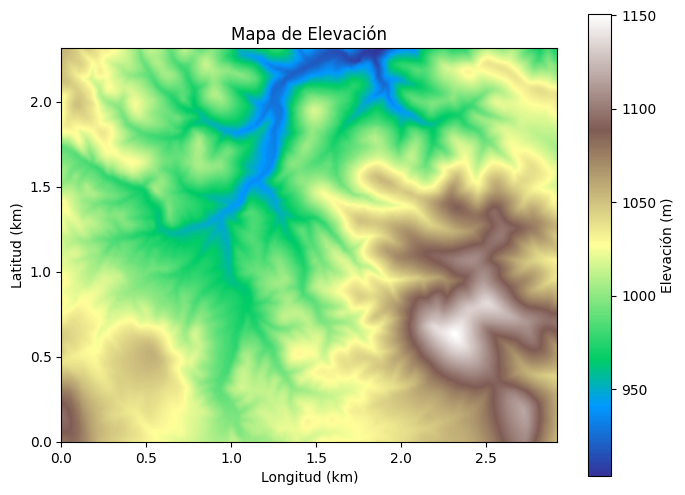

In [10]:
#OBTENER EL RELIEVE
fact=4 #factor escala para obtención del relieve
mdt_res=15 #resolución del mdt (no modificar)
fact=np.max([mdt_res/1000/((max_lat - min_lat)*111/Ny),fact])
print(f"Factor de escala utilizado: {fact}") 

elevaciones = funciones_tfg.procesar_topografia(fact,Nx,Ny,min_lon, max_lon, min_lat, max_lat, marker_lon, marker_lat)
funciones_tfg.graficar_elevacion(elevaciones,lon_distances,lat_distances)

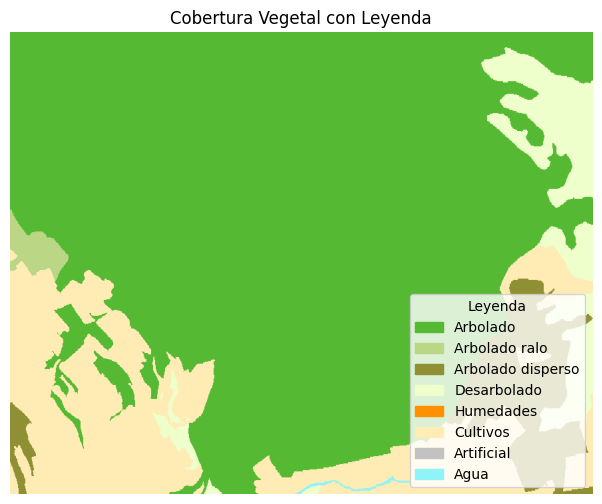

In [11]:
# MOSTRAR LA COVERTURA VEGETAL
vegetacion = funciones_tfg.procesar_cobertura_vegetal(min_lon, max_lon, min_lat, max_lat, Nx, Ny, base_res)

(876, 695) (695, 876)
(876, 695) (695, 876)
(876, 695) (876, 695)
Files written


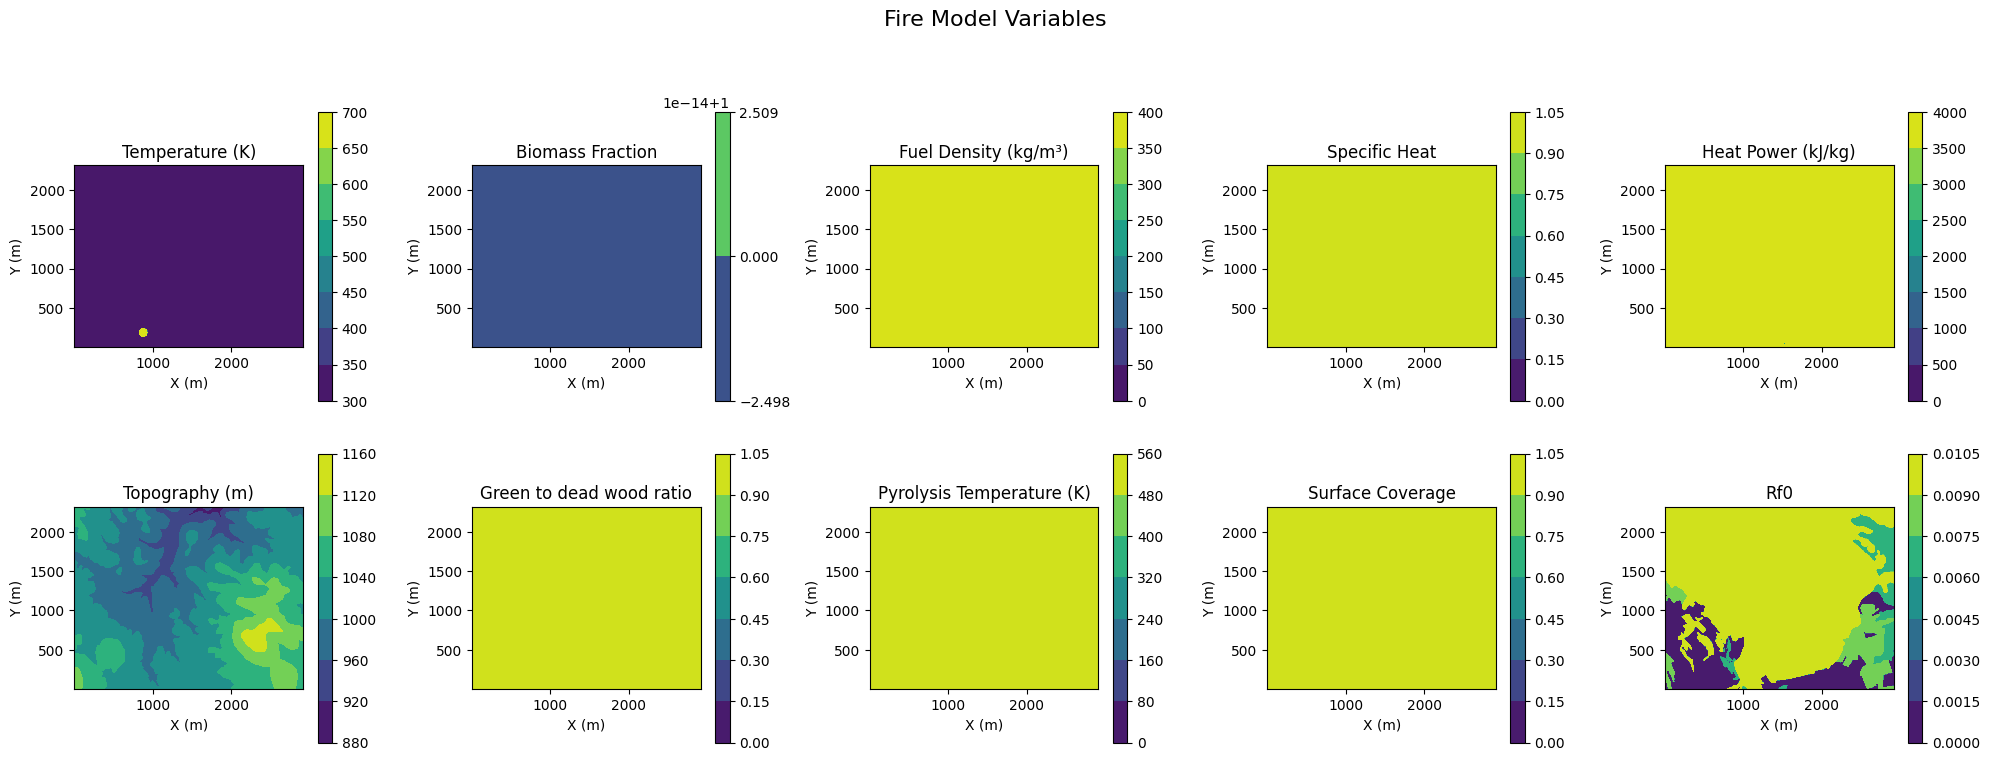

In [36]:
#Tiempo de simulación 
FinalTime=7200  # segundos

#Tiempo de volcado 
DumpTime=300  # segundos

#Radio del fuego inicial
radio=50

#Other parameters (constant in the domain) #DEFINIRLOS
u_x = 5.000  #m/s #V del viento en x
u_y = 6.500  #m/s #V del viento en y
K   = 0.00010   #kW/(m·K) #cte
h   = 0.05   #kW/(m^3·K) #como de rapido se enfria el suelo, h peuqeñas fuegos intensos, MAYOR H HACE MENOS FUEGO
Tinf= 300.0 #K
RH  = 0.0   #aodim (relative humidity) 0 a 1
L   = 1.0   #m

#DEFINIR VECTOR VALORES
#vector_xx=[Arbolado(1), Arbolado ralo(2), Arbolado disperso(3),Desarbolado(4),Humedades(5), Cultivos(6), Artificial(7), Agua(8)]
vector_rfmax=[0.010, 0.00900, 0.00800, 0.00700, 0.0060, 0.0000, 0.0000, 0.000] #maximum volumetric porosity RCDC(relacionados cantidad de combustible)  #volumen de combustible respecto al volumen total (mas arbol hay mas numero) de 0,01 hacia abajo
vector_rhof=[400 ,400 , 400 , 400, 400 , 400.0 , 400.0 , 400.0 ] #solid fuel density entorno a 600 mas o menos fijo
vector_cf=[1.00,1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00] #solid fuel specific heat entorno a 1 y dejar fijo
vector_h=[4000,4000, 4000, 4000, 4000, 4000, 4000, 0] #solid fuel heat power PODER CALORIFICO DEL COMBUSTIBLE, ENERGIA QUE SE LIBEROA POR CADA KG DE COMBUSTIBLE, mucho margen de cambio
vector_mg=[0 ,0 , 0 , 0 , 0 , 0 , 0 , 1]  #green wood water content ENTRE 0 Y 2, MODIFICABLE madera viva contenido de humedad
vector_alpha=[1,1, 1, 1, 1, 1, 0, 0]   #ratio between green and season wood ALPHA 1 TODO VIVO, ALPHA 0 TODO MUERTO  PONER TODO A 1
vector_tpc=[500,500, 500, 500, 500, 500, 500, 500] #pirolisis temperature TEMPERATURA A LA Q SE ACTIVA EL FUEGO, entre 400 y 600
vector_a=[0.01,0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]  #reaction rate MUY SENSIBLE velocidad a la q se quema entre 0,001 y 0,04
vector_sc=[1, 1, 1, 1, 1, 1, 1 ,1]  #mismo que rfmax

#matriz_xx=funciones_tfg_nuevo.crear_matriz_xx(vegetacion,vector_xx)
matriz_rfmax=funciones_tfg.crear_matriz_xx(vegetacion,vector_rfmax)
matriz_rhof=funciones_tfg.crear_matriz_xx(vegetacion,vector_rhof)
matriz_cf=funciones_tfg.crear_matriz_xx(vegetacion,vector_cf)
matriz_h=funciones_tfg.crear_matriz_xx(vegetacion,vector_h)
matriz_mg=funciones_tfg.crear_matriz_xx(vegetacion,vector_mg)
matriz_alpha=funciones_tfg.crear_matriz_xx(vegetacion,vector_alpha)
matriz_tpc=funciones_tfg.crear_matriz_xx(vegetacion,vector_tpc)
matriz_a=funciones_tfg.crear_matriz_xx(vegetacion,vector_a)
matriz_sc=funciones_tfg.crear_matriz_xx(vegetacion,vector_sc)

funciones_tfg.generar_input_simulacion(lon_distances, lat_distances, Nx, Ny, elevaciones, marker_lon, marker_lat, matriz_sc, min_lon, max_lon, min_lat, max_lat, center_lat,radio,u_x, u_y, K, h, Tinf, RH,L, matriz_rfmax,matriz_rhof,matriz_cf,matriz_h,matriz_mg,matriz_alpha,matriz_tpc,matriz_a,FinalTime,DumpTime)

In [37]:
import subprocess
import threading

timeout_seconds = 1000 #CORTAFUEGOS 

# Step 1: Run your setup script (blocking)
subprocess.run(["bash", "runFromJupyter.sh"], check=True)

# Step 2: Start euler with unbuffered output using stdbuf
process = subprocess.Popen(
    ["stdbuf", "-o0", "./euler"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)

# Function to stream output line by line
def stream_output(proc):
    for line in proc.stdout:
        print(line, end='')

# Step 3: Start thread to read output
thread = threading.Thread(target=stream_output, args=(process,))
thread.start()

# Step 4: Wait with timeout
thread.join(timeout_seconds)

# Step 5: Kill process if timeout exceeded
if thread.is_alive():
    process.kill()
    print(f"\n\nSe ha excedido el tiempo de {timeout_seconds} s establecido.")

The number of threads is set to 12.

Authors:
 - Adrián Navas Montilla
 - Isabel Echeverribar 
Copyright (C) 2019-2023 The authors.   

License type: Creative Commons Attribution-NonCommercial-NoDerivs 3.0 Spain (CC BY-NC-ND 3.0 ES under the following terms: 
 
 - Attribution — You must give appropriate credit and provide a link to the license. 
 - NonCommercial — You may not use the material for commercial purposes. 
 - NoDerivatives — If you remix, transform, or build upon the material, you may not distribute the modified material unless explicit permission of the authors is provided.

Disclaimer: This software is distributed for research and/or academic purposes, WITHOUT ANY WARRANTY. In no event shall the authors be liable for any claim, damages or other liability, arising from, out of or in connection with the software or the use or other dealings in this software.
 
 
 FIRE SIMULATION SETUP:
 WENO reconstruction of order 7 is chosen. 
 Final time: 7200.000000
 CFL: 0.400000
 Numb

In [39]:
#LECTURA DE DATOS

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import LinearRegression
import matplotlib.animation as animation
from IPython.display import HTML
from glob import glob
import os
import re


folder_base="output-files/"  #carpeta de archivos
folder_sol=""
folder_out=folder_base
type_model=1 #1: (T,Y), 2: (H,Y)

files = sorted(glob(folder_out + "/listFire0*.out"), key=lambda x: int(re.findall(r'\d+', os.path.basename(x))[0]))  #esto es para buscar archivos que empiecen por listFire0.......
lf=len(files)
print("The number of files is", lf)
#print(files)

file1 = open(files[0], 'r')
line = file1.readline()
line = file1.readline()
cells=re.findall(r'\b\d+\b',line)
xcells=int(cells[0])
ycells=int(cells[1])

print("Mesh dimensions are:",xcells,"x",ycells)
print("\nList of files read:\n")

xc=np.zeros((xcells,ycells))
yc=np.zeros((xcells,ycells))
T=np.zeros((xcells,ycells,lf))
Y=np.zeros((xcells,ycells,lf))
H=np.zeros((xcells,ycells,lf))
Rf=np.zeros((xcells,ycells,lf))
Z=np.zeros((xcells,ycells))

j=0
for fname in files:
    print(fname+" file read")
    data     = np.loadtxt(fname, skiprows=2)
    k=0
    for l in range(0,xcells):
        for m in range(0,ycells):
            xc[l,m]=data[k,0] #matriz de x
            yc[l,m]=data[k,1] #matriz de y
            T[l,m,j]=data[k,2]  #matriz de datos de Temperatura, donde l,m son dimensiones espaciales y j es el tiempo. Hay tantos valores de j como numero de archivos. Esto será lo que quieres pintar.
            Y[l,m,j]=data[k,3]
            Rf[l,m,j]=data[k,4]
            Z[l,m]=100.0*np.exp(-((xc[l,m]-200)**2+(yc[l,m]-200)**2)/20000) #topography
            if type_model==2:
                H[l,m,j]=data[k,5]
            k+=1
    j=j+1

times  = np.loadtxt(folder_out+"/times_fire.out")

The number of files is 25
Mesh dimensions are: 876 x 695

List of files read:

output-files/listFire000.out file read
output-files/listFire001.out file read
output-files/listFire002.out file read
output-files/listFire003.out file read
output-files/listFire004.out file read
output-files/listFire005.out file read
output-files/listFire006.out file read
output-files/listFire007.out file read
output-files/listFire008.out file read
output-files/listFire009.out file read
output-files/listFire010.out file read
output-files/listFire011.out file read
output-files/listFire012.out file read
output-files/listFire013.out file read
output-files/listFire014.out file read
output-files/listFire015.out file read
output-files/listFire016.out file read
output-files/listFire017.out file read
output-files/listFire018.out file read
output-files/listFire019.out file read
output-files/listFire020.out file read
output-files/listFire021.out file read
output-files/listFire022.out file read
output-files/listFire023

In [40]:
#REPRESENTACIÓN GRÁFICA

xp = xc[:, 0]     # puntos en x
yp = yc[0, :]     # puntos en y
Xp, Yp = np.meshgrid(xp, yp)

# Set levels if needed (for T)
levels = np.linspace(600, 1800, 6)  # example contour levels

# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(10.5, 4.5))
suptitle=fig.suptitle("")

def update(frame):
    # Clear both subplots
    ax[0].cla()
    ax[1].cla()

    # Extract and transpose data for this frame
    ST = np.transpose(T[:, :, frame])
    SRf = np.transpose(Rf[:, :, frame])

    # Plot temperature
    ax[0].contour(Xp, Yp, ST, levels=levels, colors="k", linewidths=0.75)
    contf1 = ax[0].contourf(Xp, Yp, ST, 200, cmap='YlOrRd')
    contf1.set_clim(300.0, 1400.0)
    ax[0].set_title('T')
    ax[0].set_xlabel("x(m)")
    ax[0].set_ylabel("y(m)")
    ax[0].set_aspect('equal', 'box')

    # Add min/max T as figure text
    fig.texts.clear()  # Clear previous frame's text
    fig.text(0.11, 0.88, f"T_max = {np.max(ST):.1f} K", fontsize=9)
    fig.text(0.11, 0.83, f"T_min = {np.min(ST):.1f} K", fontsize=9)
    fig.text(0.4, 0.95, f"Tiempo: {times[frame]:.1f} s ({(times[frame]/3600):.1f} horas)", fontsize=11)
    
    # Plot Rf (W)
    contf2 = ax[1].contourf(Xp, Yp, SRf * matriz_rhof, 200, cmap='BrBG')
    ax[1].contour(Xp, Yp, SRf * matriz_rhof, 6, colors="k", linewidths=0.75)
    #contf2.set_clim(0.0, 4.00)
    ax[1].set_title('W')
    ax[1].set_xlabel("x(m)")
    ax[1].set_ylabel("y(m)")
    ax[1].set_aspect('equal', 'box')
    #suptitle.set_text(f"Tiempo: {times[frame]:.3f} s")

    return contf1.collections + contf2.collections

ani = animation.FuncAnimation(fig, update, frames=lf, interval=50)
plt.close(fig)
HTML(ani.to_jshtml()) 


The number of files is 25
Mesh dimensions are: 876 x 695

List of files read:

output-files/listFire000.out file read
output-files/listFire001.out file read
output-files/listFire002.out file read
output-files/listFire003.out file read
output-files/listFire004.out file read
output-files/listFire005.out file read
output-files/listFire006.out file read
output-files/listFire007.out file read
output-files/listFire008.out file read
output-files/listFire009.out file read
output-files/listFire010.out file read
output-files/listFire011.out file read
output-files/listFire012.out file read
output-files/listFire013.out file read
output-files/listFire014.out file read
output-files/listFire015.out file read
output-files/listFire016.out file read
output-files/listFire017.out file read
output-files/listFire018.out file read
output-files/listFire019.out file read
output-files/listFire020.out file read
output-files/listFire021.out file read
output-files/listFire022.out file read
output-files/listFire023

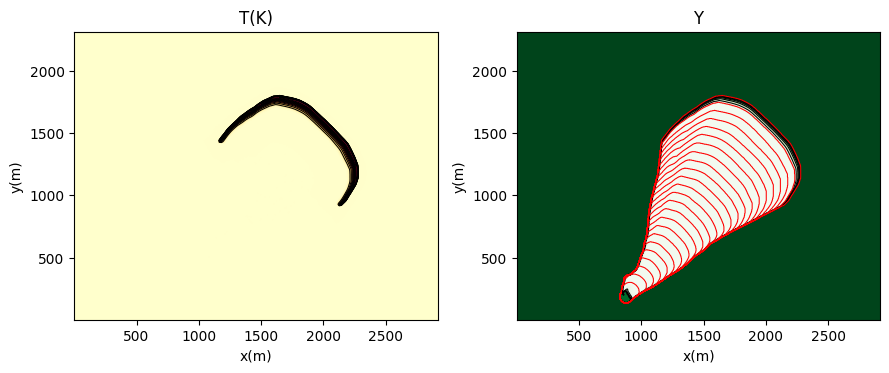

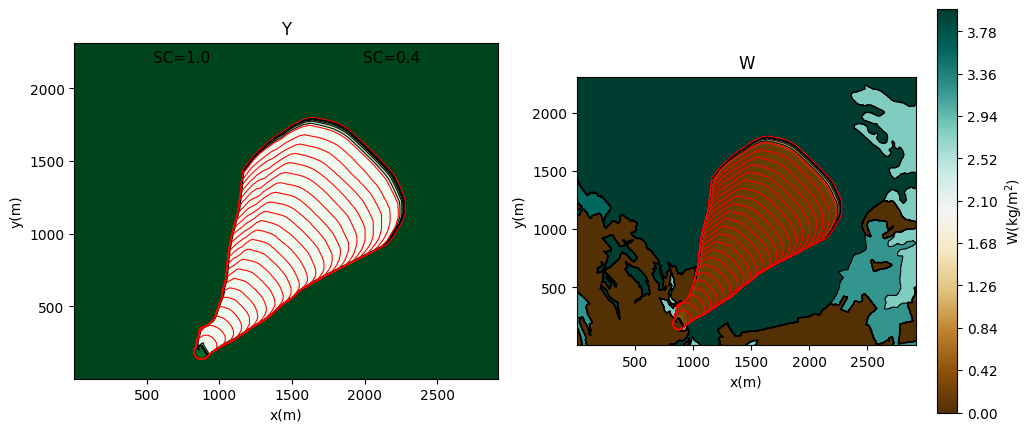

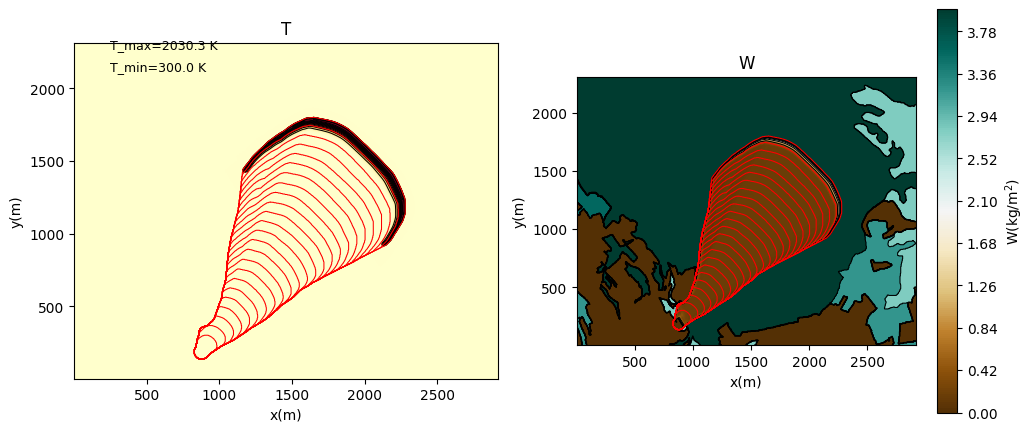

In [41]:
%run firePlotting.py